In [121]:
import json
import math
from typing import List, Counter

import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from evaluation import Evaluator
import settings as cfg

In [122]:
# Load Training data
with open("spider_data/spider_data/train_spider.json", "r") as f:
    train_spider_data = json.load(f)
with open("spider_data/spider_data/train_others.json", "r") as f:
    train_others_data = json.load(f)
train_data = train_spider_data + train_others_data

In [123]:
# Create Dataframes
train_data_df = pd.DataFrame(train_data)

In [124]:
# Inspect Dataframes
print(train_data_df.columns)

Index(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question',
       'question_toks', 'sql'],
      dtype='object')


In [125]:
# Print first row of train_data Dataframe
train_data_df.iloc[1]

db_id                                              department_management
query                  SELECT name ,  born_state ,  age FROM head ORD...
query_toks             [SELECT, name, ,, born_state, ,, age, FROM, he...
query_toks_no_value    [select, name, ,, born_state, ,, age, from, he...
question               List the name, born state and age of the heads...
question_toks          [List, the, name, ,, born, state, and, age, of...
sql                    {'from': {'table_units': [['table_unit', 1]], ...
Name: 1, dtype: object

In [126]:
with open("resources/en_50k.txt", "r", encoding="utf-8") as f:
    frequent_words = set(map(lambda x: x.split(" ")[0], f.readlines()))

with open("resources/en_full.txt", "r", encoding="utf-8") as f:
    rare_words = set([line.split(" ")[0] for line in f.readlines() if int(line.split(" ")[1]) < cfg.RARE_WORD_THRESHOLD])

nlp = spacy.load("en_core_web_sm")


def extract_features(question):
    doc = nlp(question)

    # general
    features = {
        "num_tokens": len(doc),
        "is_wh_question": any(token.text.lower() in ["what", "where", "who", "how", "why"] for token in doc),
        "has_negation": any(token.text.lower() in ["not", "no"] for token in doc),
        "num_entities": len(doc.ents),
        "num_unique_dependencies": len(set(token.dep_ for token in doc)),
        "max_head_distance": max([token.head.i for token in doc] + [0]),
        "max_subtree_size": max([len(list(token.subtree)) for token in doc] + [0]),
    }

    # POS-Tagging
    pos_counts = Counter(token.pos_ for token in doc)
    features.update({
        "num_nouns": pos_counts.get("NOUN", 0),
        "num_verbs": pos_counts.get("VERB", 0),
        "num_adjectives": pos_counts.get("ADJ", 0),
        "num_adverbs": pos_counts.get("ADV", 0),
    })

    # count entities for type
    entity_counts = Counter(ent.label_ for ent in doc.ents)
    features.update({
        "num_persons": entity_counts.get("PERSON", 0),
        "num_orgs": entity_counts.get("ORG", 0),
        "num_locations": entity_counts.get("GPE", 0),
    })

    # frequent words
    # Log frequency of words int question that are frequent words
    try:
        features["frequent_tokens"] = -math.log(sum([1 for token in doc if str(token).lower() in frequent_words]) / len(doc))
    except (ValueError, ZeroDivisionError):
        features["frequent_tokens"] = 0

    # rare words
    try:
        features["rare_tokens"] = -math.log(sum([1 for token in doc if str(token).lower() in rare_words]) / len(doc))
    except (ValueError, ZeroDivisionError):
        features["rare_tokens"] = 0

    return features

In [127]:
# Extract linguistic features
train_data_df["linguistic_features"] = train_data_df["question"].apply(extract_features)

# feature names (for dynamic access to "linguistic features" columns)
features = list(extract_features("").keys())

In [128]:
# Extend Dataframe with the extracted features
train_df = pd.concat([train_data_df, train_data_df["linguistic_features"].apply(pd.Series)], axis=1)

In [129]:
# Show first row of with linguistic features extended Dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(train_df.iloc[[0,1,2]])


,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql,linguistic_features,num_tokens,is_wh_question,has_negation,num_entities,num_unique_dependencies,max_head_distance,max_subtree_size,num_nouns,num_verbs,num_adjectives,num_adverbs,num_persons,num_orgs,num_locations,frequent_tokens,rare_tokens
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ...","{'num_tokens': 11, 'is_wh_question': True, 'ha...",11,True,False,1,9,8,11,2,0,2,0,0,0,0,0.200671,0.0
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ...","{'num_tokens': 17, 'is_wh_question': False, 'h...",17,False,False,0,12,14,17,6,3,0,0,0,0,0,0.125163,0.0
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ...","{'num_tokens': 12, 'is_wh_question': False, 'h...",12,False,False,1,9,10,12,5,1,0,0,0,0,0,0.182322,0.0


## Get the Diffuculty Level using Spiders Evaluator

https://github.com/taoyds/spider/blob/master/evaluation.py#L362

In [130]:
evaluator = Evaluator()

train_df["hardness"] = train_df["sql"].apply(lambda sql: evaluator.eval_hardness(sql))
small_train_data_df = train_df[["query", "question", "hardness", *features]]

In [131]:
small_train_data_df.head(5)

,query,question,hardness,num_tokens,is_wh_question,has_negation,num_entities,num_unique_dependencies,max_head_distance,max_subtree_size,num_nouns,num_verbs,num_adjectives,num_adverbs,num_persons,num_orgs,num_locations,frequent_tokens,rare_tokens
0,SELECT count(*) FROM head WHERE age > 56,How many heads of the departments are older th...,easy,11,True,False,1,9,8,11,2,0,2,0,0,0,0,0.200671,0.0
1,"SELECT name , born_state , age FROM head ORD...","List the name, born state and age of the heads...",medium,17,False,False,0,12,14,17,6,3,0,0,0,0,0,0.125163,0.0
2,"SELECT creation , name , budget_in_billions ...","List the creation year, name and budget of eac...",medium,12,False,False,1,9,10,12,5,1,0,0,0,0,0,0.182322,0.0
3,"SELECT max(budget_in_billions) , min(budget_i...",What are the maximum and minimum budget of the...,medium,11,True,False,0,10,9,11,2,0,2,0,0,0,0,0.095310,0.0
4,SELECT avg(num_employees) FROM department WHER...,What is the average number of employees of the...,easy,18,True,False,1,13,14,18,4,0,1,0,0,0,0,0.182322,0.0


In [132]:
groups = small_train_data_df.groupby(["hardness"])

In [133]:
# Nice colors for plotting :)
colors = {
    "easy": "#FF6F91",    # Pink
    "medium": "#FF9671",   # Orange
    "hard": "#6A9EFF",     # Blue
    "extra": "#A277FF"     # Purple
}

hardness_order = ['easy', 'medium', 'hard', 'extra']

## Boxplot number of Tokens per Difficulty Level

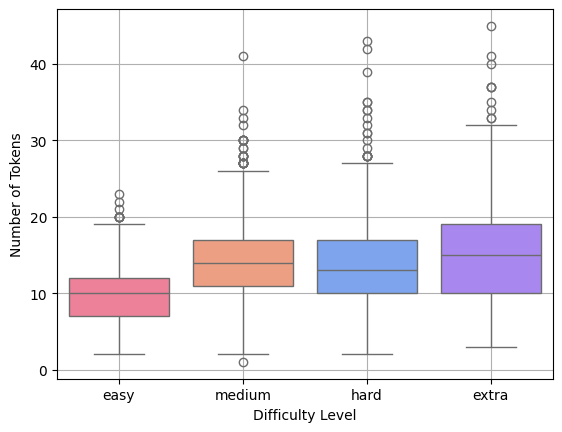

In [134]:
sns.boxplot(x="hardness", y="num_tokens", data=small_train_data_df, palette=colors, hue="hardness")
plt.xlabel("Difficulty Level")
plt.ylabel("Number of Tokens")
plt.grid(True)
plt.show()

The more tokens in the question, the higher the difficulty level. <br>
Conclusion: No significant differences.

## Compare the ratio num_query_toks / num_tokens per Hardness Level.
Determine whether the length of SQL queries, relative to the Length of questions, correlates with the difficulty of the tasks. (num_query_toks/num_tokens = e.g. are the queries shorter than the question? )

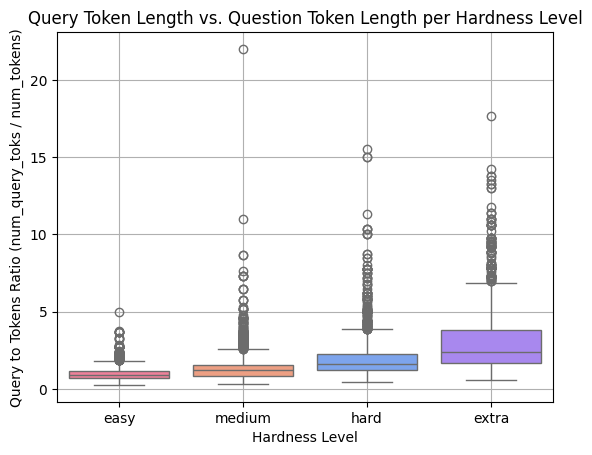

In [135]:
train_df['num_query_toks'] = train_df['query_toks'].apply(len)

train_df['query_to_tokens_ratio'] = train_df['num_query_toks'] / train_df['num_tokens']

sns.boxplot(x='hardness', y='query_to_tokens_ratio', data=train_df, palette=colors, hue='hardness')
plt.title('Query Token Length vs. Question Token Length per Hardness Level')
plt.xlabel('Hardness Level')
plt.ylabel('Query to Tokens Ratio (num_query_toks / num_tokens)')
plt.grid(True)
plt.show()

Queries are longer with questions of the same length.

## Number of POS per hardness level

In [149]:
def plot_per_hardness_level(results: List[float], labels: List[str], plot_count: int = 3) -> None:
    """
    TODO:
    """
    _, axes = plt.subplots(1, plot_count, figsize=(18, 5))
    
    for i, (res, title) in enumerate(zip(results, labels)):
        res = res.loc[["easy", "medium", "hard", "extra"]]
        
        axes[i].plot(res.index, res.values, marker='o', linestyle='-', color='pink', lw=6)
        axes[i].set_title(title)
        axes[i].set_xlabel("Hardness")
        axes[i].set_ylabel("Adjectives per Token")
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

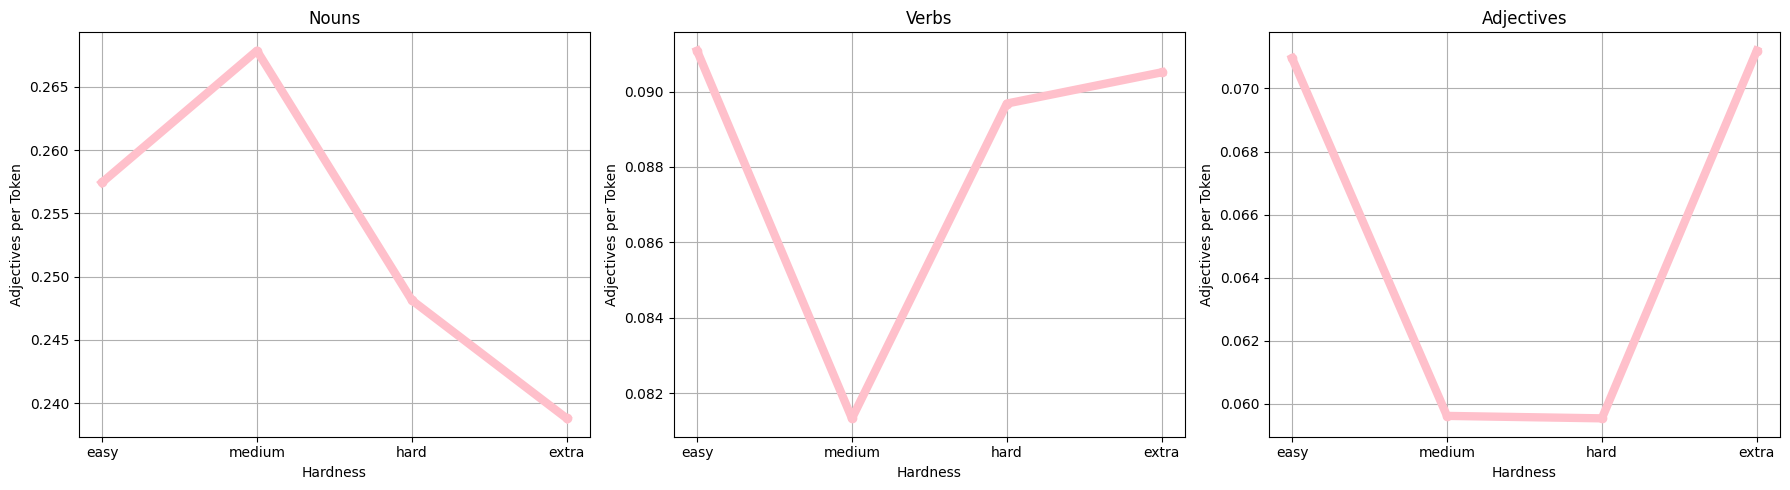

In [150]:
results = [
    groups["num_nouns"].mean() / groups["num_tokens"].mean(),
    groups["num_verbs"].mean() / groups["num_tokens"].mean(),
    groups["num_adjectives"].mean() / groups["num_tokens"].mean()
]

plot_per_hardness_level(results=results, labels=["Nouns", "Verbs", "Adjectives"])

The Number of Nouns is the highes at difficulty level medium, while being the least at extra. <br>
The number of Verbs is the higghest at difficulty level easy, while the least amount is at medium. <br>
The number of adjectives is the highest at easy and extra, while being the least at medium and hard. <br><br>

*Note: Because the numbers are very small, it could imply that the trend or variation we're observing doesn't seem to be very significant.*

## Number of Named Entities per hardness level

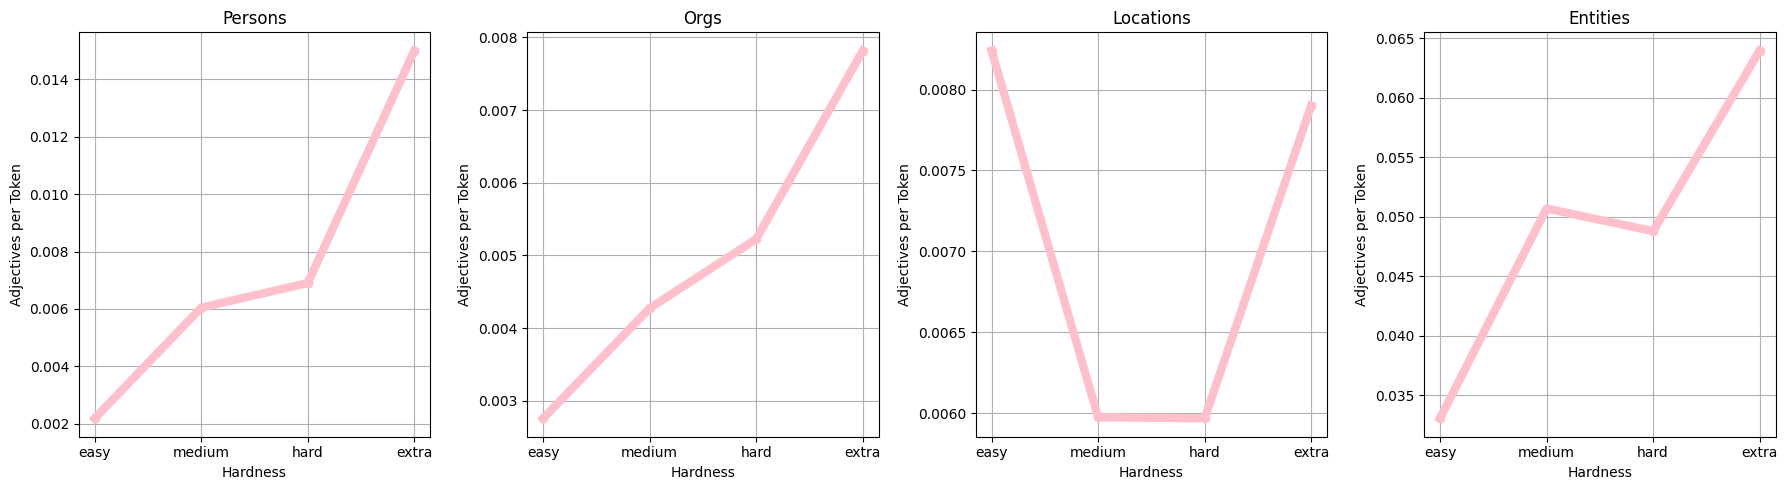

In [151]:
results = []
for col in ["num_persons", "num_orgs", "num_locations", "num_entities"]:
    normed = train_df[col] / train_df["num_tokens"].mean()
    grouped = normed.groupby(train_df["hardness"]).mean()
    results.append(grouped)

labels = ["Persons", "Orgs", "Locations", "Entities"]

plot_per_hardness_level(results=results, labels=labels, plot_count=4)

The Number of Persons, Organisations and Entities are the highest at extra difficulty. <br>
Persons und Organisations rise steadily, with a slightly lower gradient between medium and hard for Persons (meaning there is not a significant difference between medium and hard for Persons). <br>
Hard has less Entities than medium, but extra has then again much more Entities than all the other difficulty levels. <br>
It is noticeable that both medium and hard have far fewer locations than easy or extra, with easy having the largest proportion of locations. <br>

*Note: Because the numbers are very small, it could imply that the trend or variation we're observing doesn't seem to be very significant.*

## Plot number of query tokens against number of question tokens

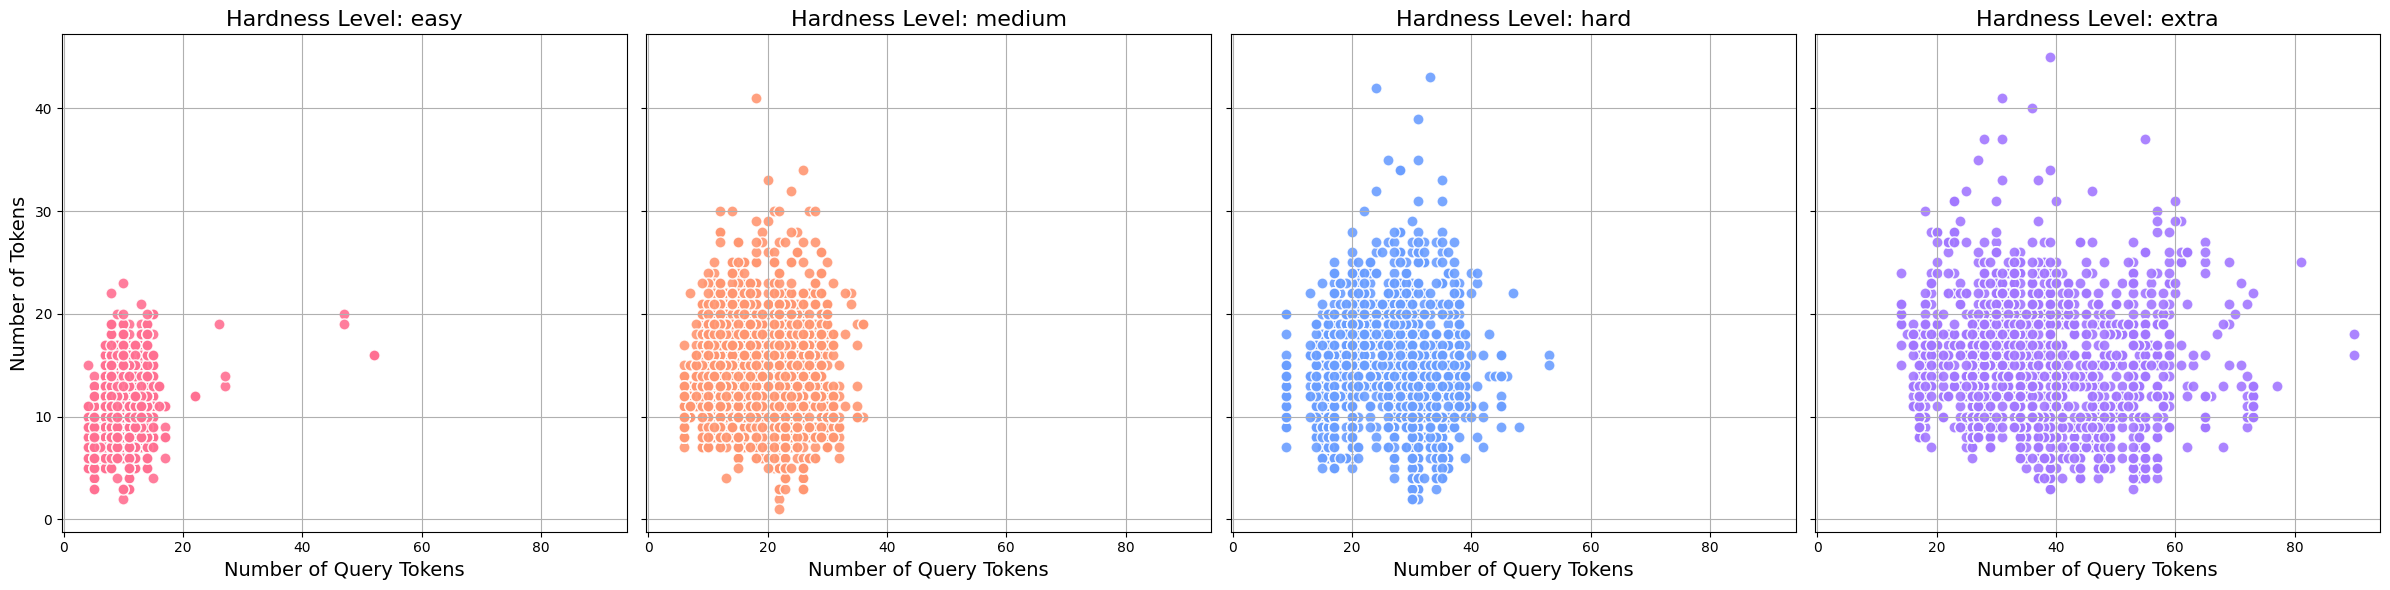

In [139]:
def plot_query_toks_to_num_toks_in_hardness_splits(train_df):
    train_df['num_query_toks'] = train_df['query_toks'].apply(len)

    hardness_levels = list(colors.keys())

    _, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True, sharex=True)

    for i, hardness in enumerate(hardness_levels):
        subset = train_df[train_df['hardness'] == hardness]
        
        axes[i].scatter(
            subset['num_query_toks'], subset['num_tokens'], 
            color=colors[hardness], s=64, alpha=0.9, edgecolor="white"
        )
        axes[i].set_title(f'Hardness Level: {hardness}', fontsize=16)
        axes[i].set_xlabel('Number of Query Tokens', fontsize=14)
        
        if i == 0:
            axes[i].set_ylabel('Number of Tokens', fontsize=14)
        
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

plot_query_toks_to_num_toks_in_hardness_splits(train_df)

The scatter plots show where increasing query hardness ('easy' to 'extra') corresponds with a rise in both the number of query tokens and tokens. <br>'Easy' queries are clustered around low values for both metrics, while 'medium' and 'hard' queries expand this range, in particular along the number of query tokens axis. <br> The 'extra' hardness level shows the most scattered pattern, with high variability across both axes, indicating that complex queries tend to be longer and more diverse in structure.

In [140]:
groups["is_wh_question"].mean()

hardness
easy      0.593041
extra     0.570940
hard      0.569199
medium    0.543515
Name: is_wh_question, dtype: float64

The difference is relatively small across all difficulty levels, while easy has the most of wh-questions.

## Average ```max_head_distance``` and ```max_subtree_size``` per Hardness Level

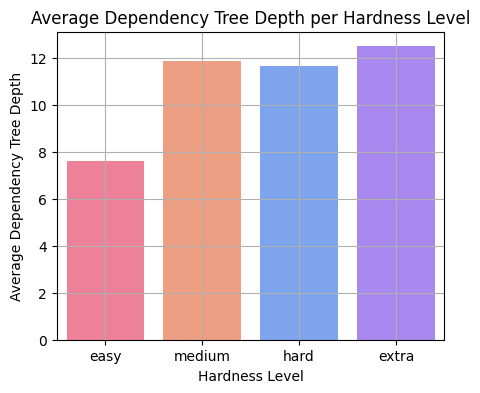

In [141]:
avg_depth_per_hardness = train_df.groupby('hardness')['max_head_distance'].mean().reset_index()

plt.figure(figsize=(5, 4))

sns.barplot(x='hardness', y='max_head_distance', data=avg_depth_per_hardness, palette=colors, hue='hardness', order=hardness_order)
plt.title('Average Dependency Tree Depth per Hardness Level')
plt.xlabel('Hardness Level')
plt.ylabel('Average Dependency Tree Depth')
plt.grid(True)
plt.show()

The Difficulty levels medium and extra have the most complex sentence structures.

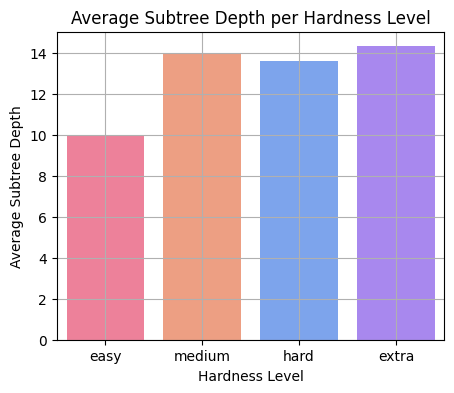

In [142]:
avg_subtree_depth_per_hardness = train_df.groupby('hardness')['max_subtree_size'].mean().reset_index()

plt.figure(figsize=(5, 4))

sns.barplot(x='hardness', y='max_subtree_size', data=avg_subtree_depth_per_hardness, palette=colors, hue='hardness', order=hardness_order)
plt.title('Average Subtree Depth per Hardness Level')
plt.xlabel('Hardness Level')
plt.ylabel('Average Subtree Depth')
plt.grid(True)
plt.show()

The Difficulty levels medium and extra have the most complex sentence structures.

When both ```max_subtree_size``` and ```max_head_distance``` are high, the sentencea are complex due to deep syntactic structure and long-distance dependencies.

## Plot Histogram for num_tokens by Hardness Level

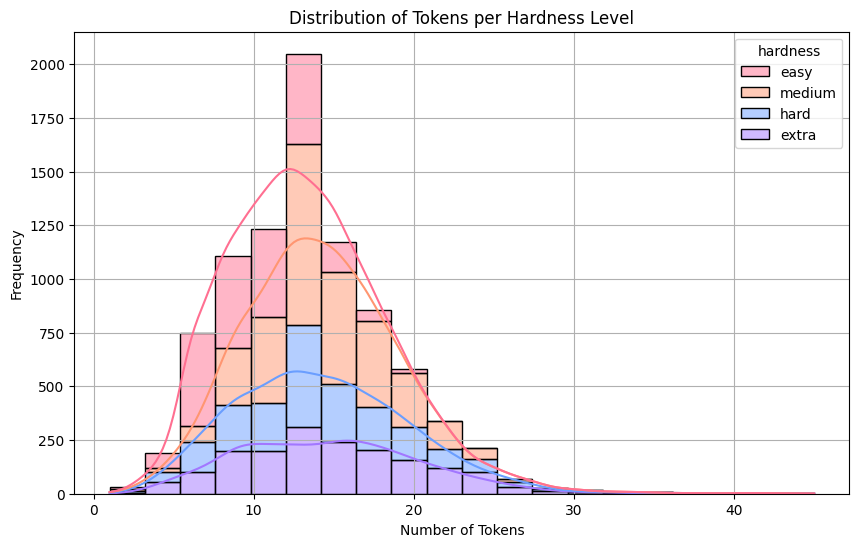

In [143]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='num_tokens', hue='hardness', kde=True, multiple="stack", bins=20, palette=colors)
plt.title('Distribution of Tokens per Hardness Level')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

It is noticeable that Easy generally has fewer tokens. <br> 
Otherwise, the distributions are relatively balanced.

## Average Type-Token Ratio (TTR) per Hardness Level

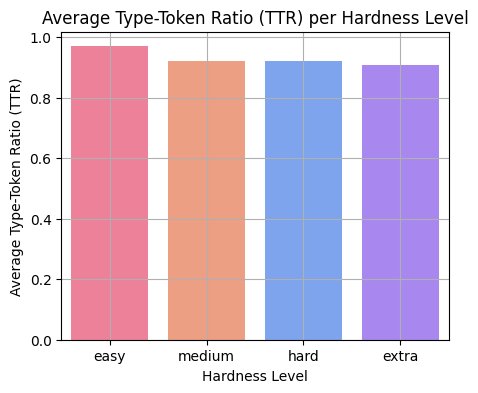

In [144]:
train_df['unique_words'] = train_df['question_toks'].apply(lambda x: len(set(x)))

train_df['TTR'] = train_df['unique_words'] / train_df['num_tokens']

avg_TTR_per_hardness = train_df.groupby('hardness')['TTR'].mean().reset_index()
avg_TTR_per_hardness['hardness'] = pd.Categorical(avg_TTR_per_hardness['hardness'], categories=hardness_order, ordered=True)

plt.figure(figsize=(5, 4))
sns.barplot(x='hardness', y='TTR', data=avg_TTR_per_hardness, palette=colors, hue='hardness')
plt.title('Average Type-Token Ratio (TTR) per Hardness Level')
plt.xlabel('Hardness Level')
plt.ylabel('Average Type-Token Ratio (TTR)')
plt.grid(True)
plt.show()

Lexical diversity (the ratio of unique words to total words) in the questions doesn't differ significantly based on their difficulty. <br>
Easy questions show a slightly higher ```TTR``` compared to the other difficulty levels. This means that, on average, easy questions use a very slightly higher variety of words relative to their length than medium, hard, or extra-hard questions.

## Distribution of frequent and rare words

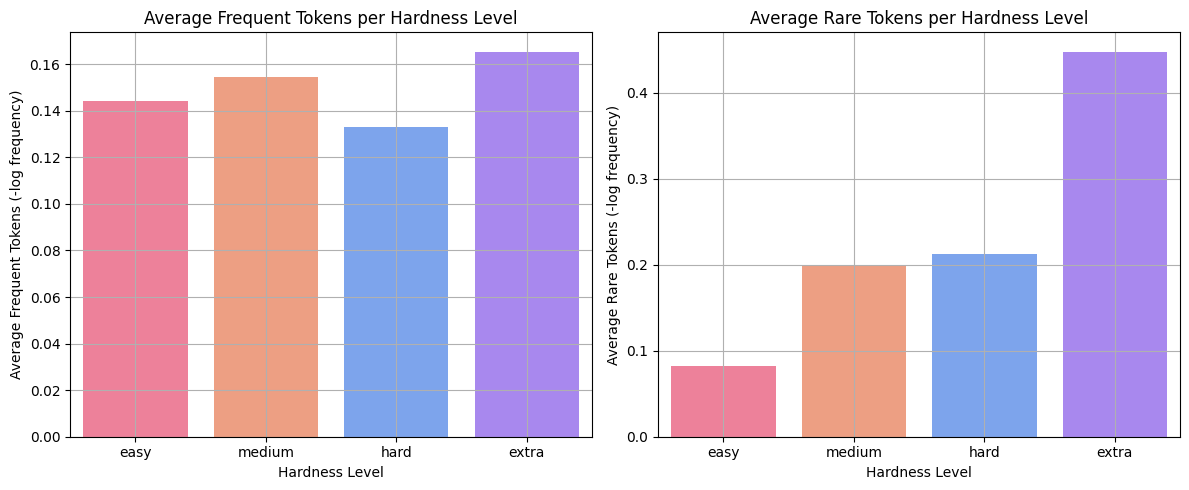

In [145]:
avg_frequent_tokens = train_df.groupby('hardness')['frequent_tokens'].mean().reset_index()
avg_rare_tokens = train_df.groupby('hardness')['rare_tokens'].mean().reset_index()

avg_frequent_tokens['hardness'] = pd.Categorical(avg_frequent_tokens['hardness'], categories=hardness_order, ordered=True)
avg_rare_tokens['hardness'] = pd.Categorical(avg_rare_tokens['hardness'], categories=hardness_order, ordered=True)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x='hardness', y='frequent_tokens', data=avg_frequent_tokens, palette=colors, hue='hardness', ax=axes[0])
axes[0].set_title('Average Frequent Tokens per Hardness Level')
axes[0].set_xlabel('Hardness Level')
axes[0].set_ylabel('Average Frequent Tokens (-log frequency)')
axes[0].grid(True)

sns.barplot(x='hardness', y='rare_tokens', data=avg_rare_tokens, palette=colors, hue='hardness', ax=axes[1])
axes[1].set_title('Average Rare Tokens per Hardness Level')
axes[1].set_xlabel('Hardness Level')
axes[1].set_ylabel('Average Rare Tokens (-log frequency)')
axes[1].grid(True)

plt.tight_layout()
plt.show()


Both frequent and rare words occur the most in the extra difficulty level. <br> 
Hard has the least frequent words. <br>
Easy has the fewest rare words, while extra stands out with a significantly higher number of rare words (approximately double as much as medium and hard).

## Distribution of Average Sentence Length

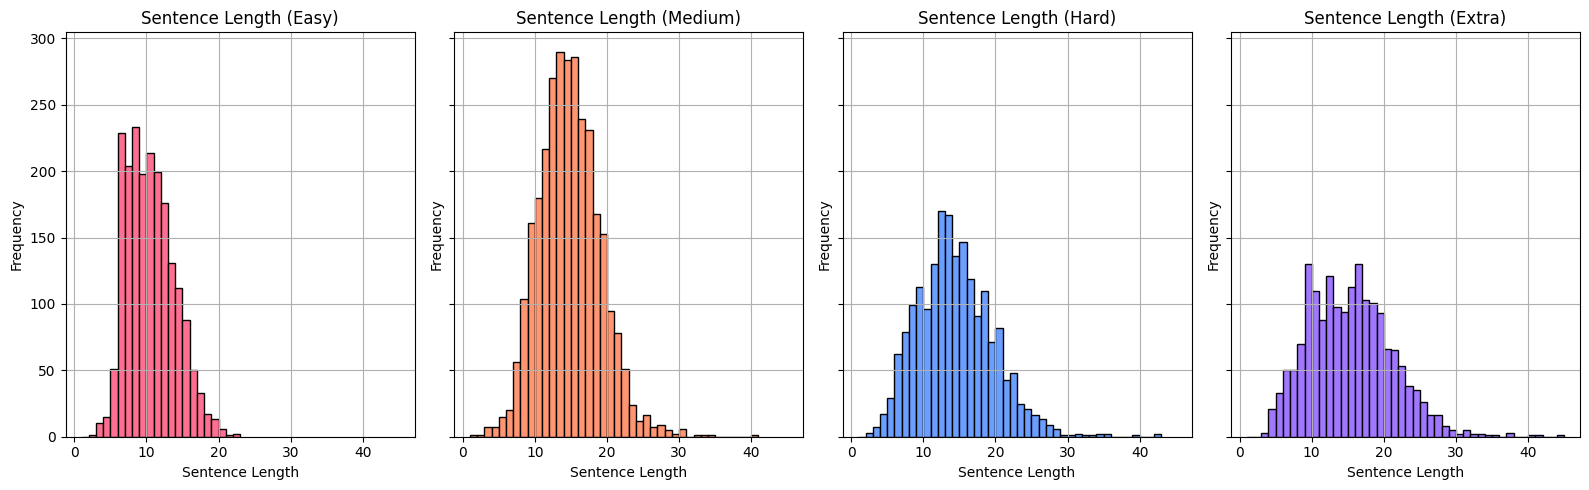

In [146]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True, sharex=True)

for i, difficulty in enumerate(hardness_order):
    ax = axes[i]
    # Get the subset of data for the current difficulty level
    subset = train_df[train_df['hardness'] == difficulty]
    
    # Plot the histogram of sentence lengths
    ax.hist(subset['num_tokens'], bins=range(1, max(subset['num_tokens']) + 1), color=colors[difficulty], edgecolor='black')
    
    ax.set_title(f'Sentence Length ({difficulty.capitalize()})')
    ax.set_xlabel('Sentence Length')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()


All sentences are approximately of the same length. <br>
For hard and extra, the sentence length is a bit more evenly distributed.

## Pearson Correlation Matrix

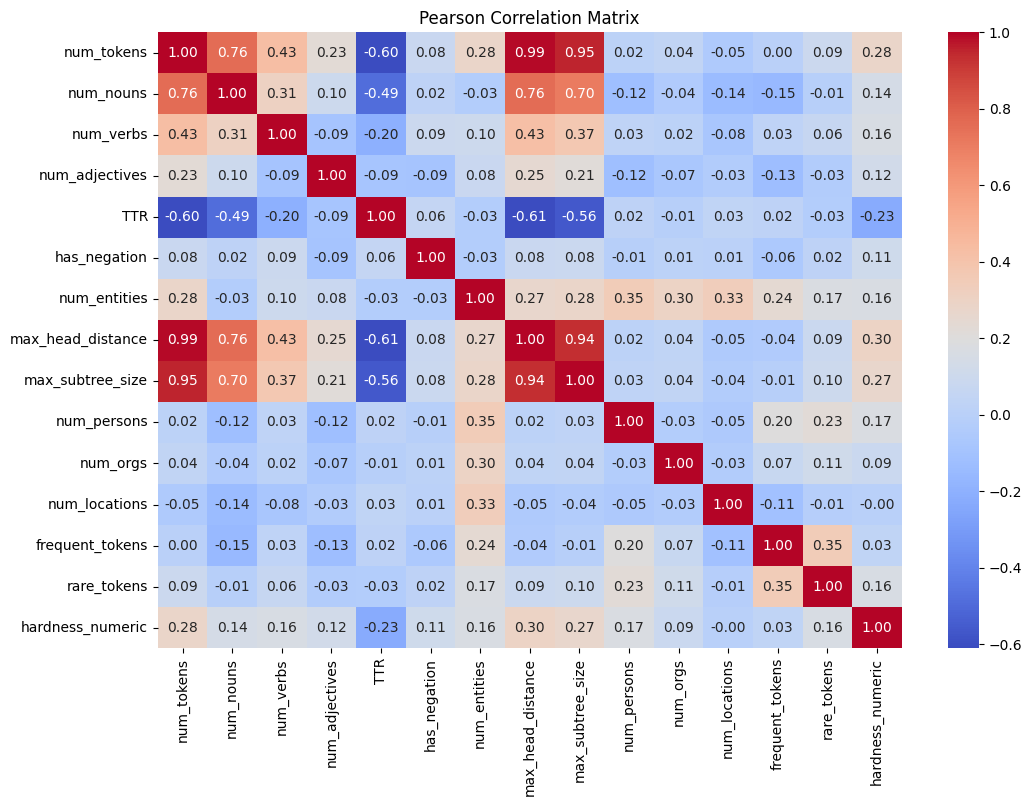

In [147]:
hardness_mapping = {'easy': 0, 'medium': 1, 'hard': 2, 'extra': 3}
train_df['hardness_numeric'] = train_df['hardness'].map(hardness_mapping)

# List of numeric columns for correlation analysis
numeric_columns = ['num_tokens', 'num_nouns', 'num_verbs', 'num_adjectives', 'TTR', 'has_negation', 'num_entities', 'max_head_distance', 'max_subtree_size', 
                   'num_persons', 'num_orgs', 'num_locations', 'frequent_tokens', 'rare_tokens']


# Pearson Correlation
pearson_corr = train_df[numeric_columns + ['hardness_numeric']].corr()
# Plot Pearson Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.show()


A strong negative correlation between ```num_tokens```, ```num_nouns```, ```max_head_distance```, ```max_subtree_size``` and ```TTR``` indicates that more complex sentence structures tend to be associated with lower lexical diversity. <br> This suggests that as the syntactic complexity of queries increases, the vocabulary becomes more repetitive or less diverse. <br> <br>

A strong positive correlation between ```num_tokens```, ```num_nouns```, ```max_subtree_size```, and ```max_head_distance```, ```max_subtree_size``` suggests that longer, more complex sentences tend to have greater syntactic distance between words. <br> <br>

A slight negative correlation between ```TTR``` and ```hardness_numeric``` could suggest that more difficult questions tend to have less varied vocabulary, while easier questions may have a greater diversity of words.